In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import rocks
rocks.set_log_level("error")
import time as t


from astropy.time import Time
import requests
import io

import astropy.units as u
from astropy.coordinates import SkyCoord
# from astropy.coordinates import angular_separation

from scipy.signal import argrelextrema

import ssptools


import fink_utils.sso.spins as finkus

from fink_spins.model import HG, HG1G2, sHG1G2
from fink_spins.plots import plot_lightcurve, plot_phase, compare_model_lc, compare_model_phase, plot_lc_multiband, plot_phase_multiband

In [3]:
save_plot = False

target = '1465'

## Load model

In [4]:
hg = HG('g', target)
hg1g2 = HG1G2('g', target)
shg1g2 = sHG1G2('g', target)

In [5]:
shg1g2.get_data_model()

(12.554574012756348,
 0.7838727235794067,
 0.11447125673294067,
 222.71926879882812,
 17.40442657470703,
 0.5500398874282837)

## Plot lighcurves

### HG
#### 'g' band

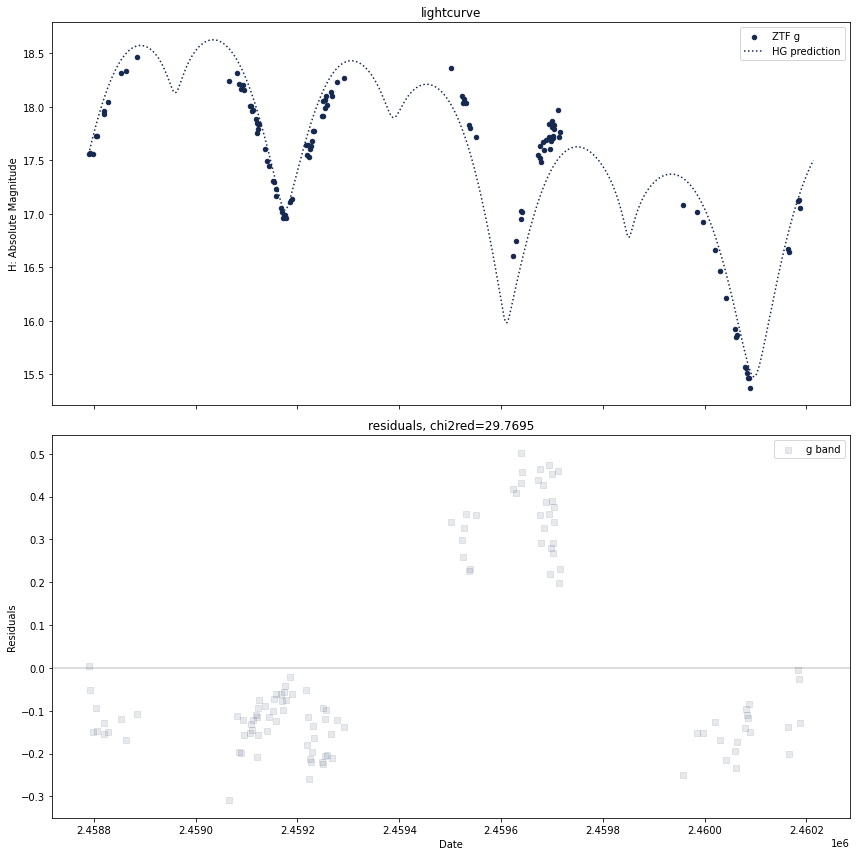

In [6]:
plot_lightcurve(hg, save_plot)

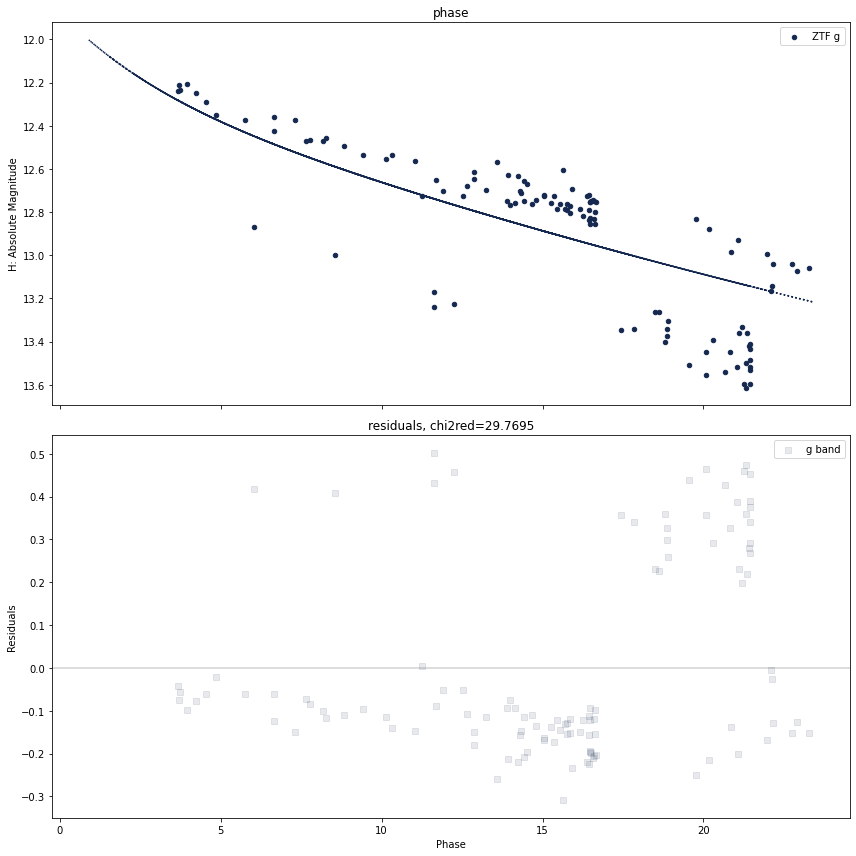

In [7]:
plot_phase(hg, save_plot)

#### 'r' band

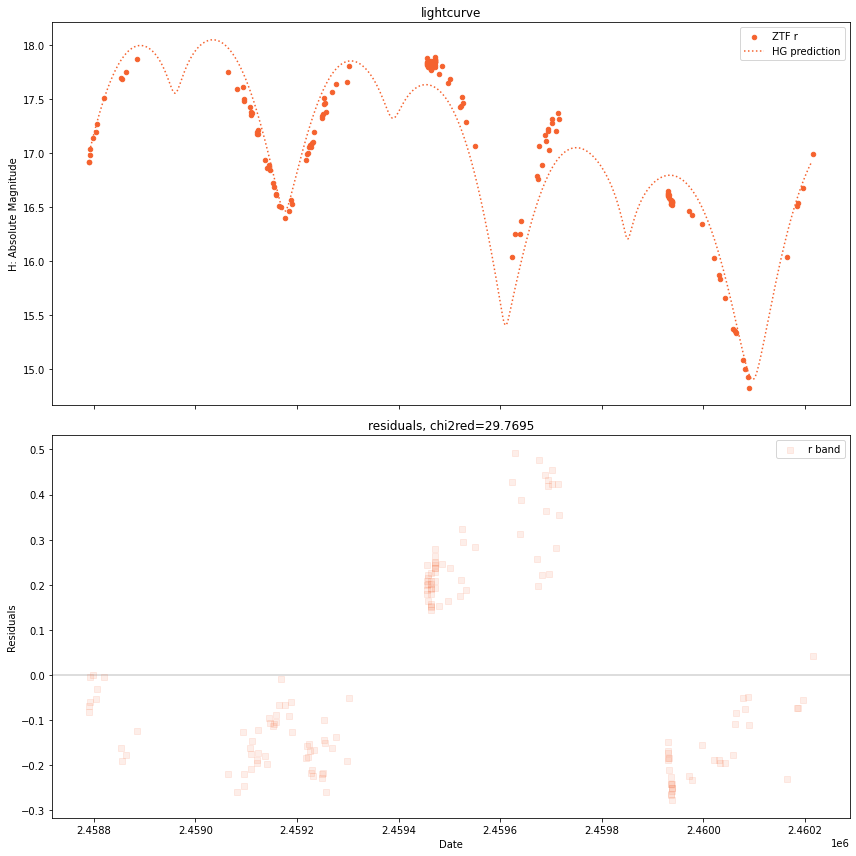

In [8]:
hg.reset_filter("r")
plot_lightcurve(hg, save_plot)

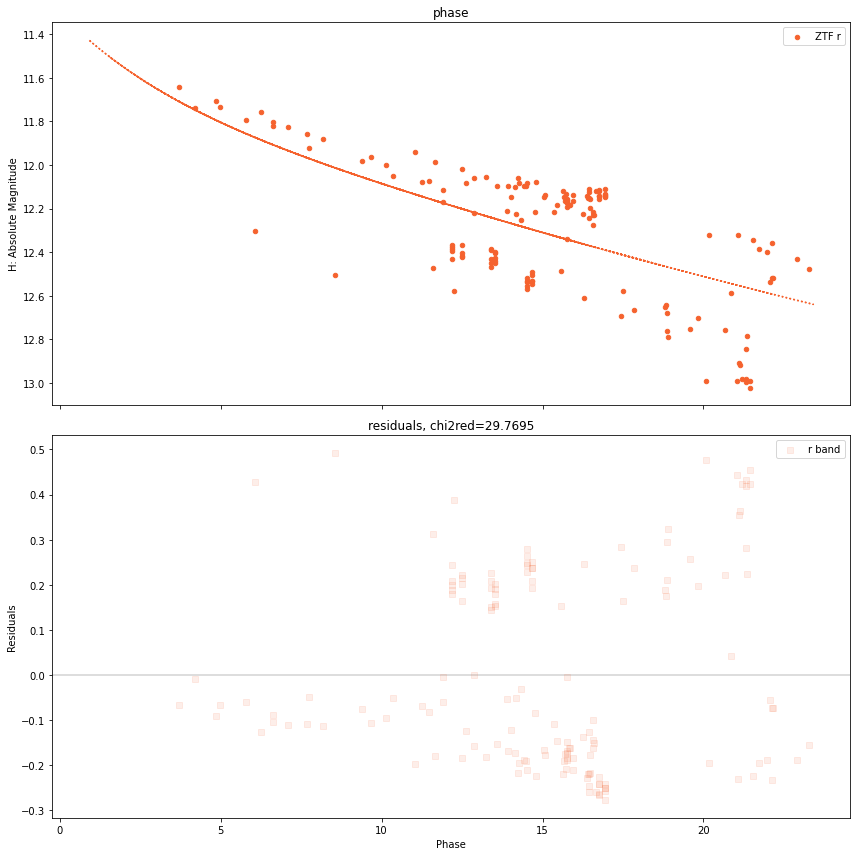

In [9]:
plot_phase(hg, save_plot)

### HG1G2
#### 'g' band

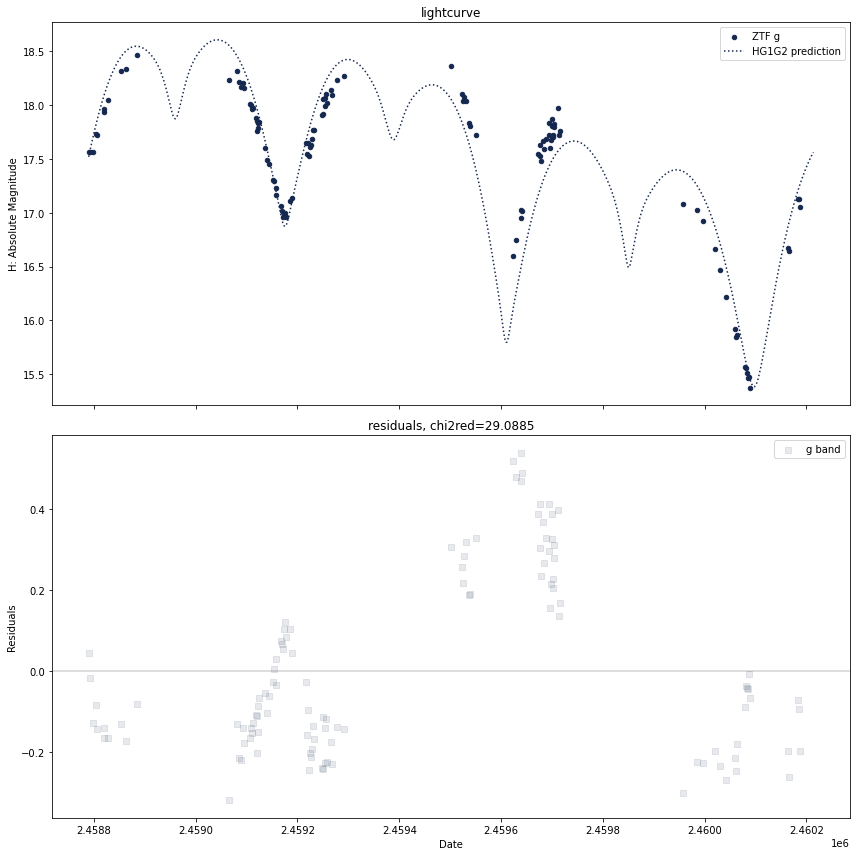

In [10]:
plot_lightcurve(hg1g2, save_plot)

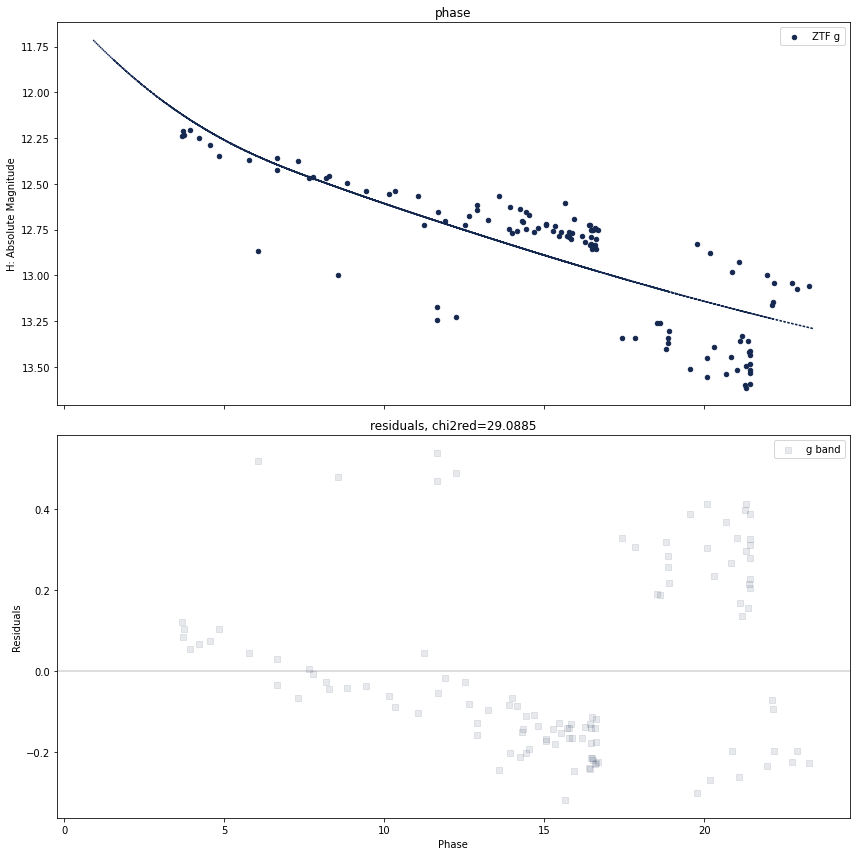

In [11]:
plot_phase(hg1g2, save_plot)

#### 'r' band

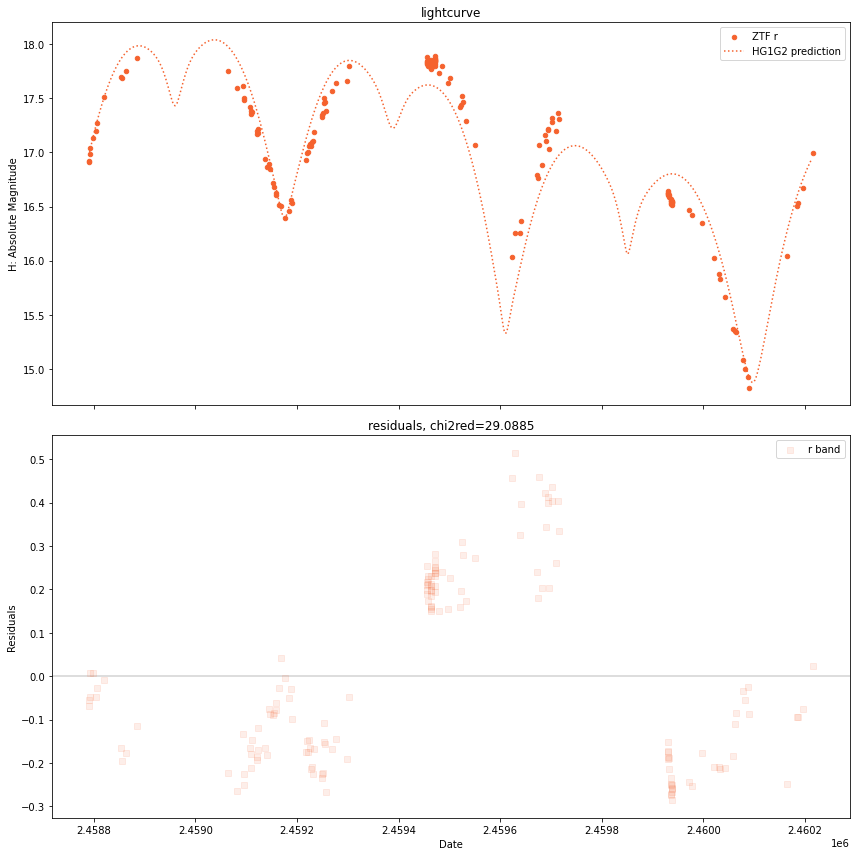

In [12]:
hg1g2.reset_filter('r')
plot_lightcurve(hg1g2, save_plot)

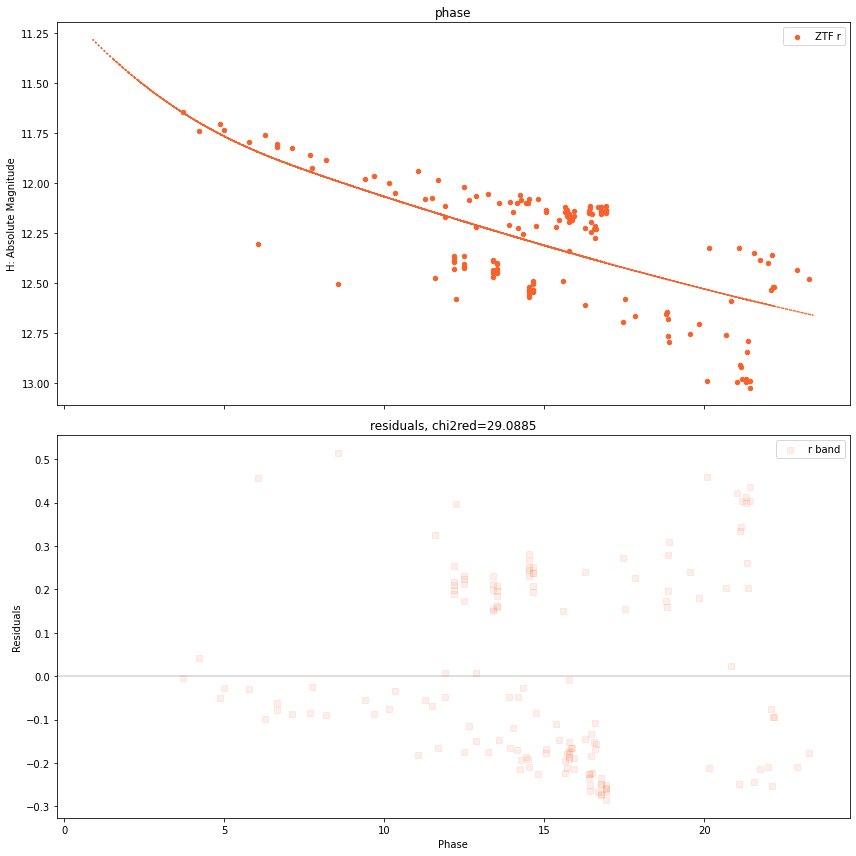

In [13]:
plot_phase(hg1g2, save_plot)

### sHG1G2
#### 'g' band

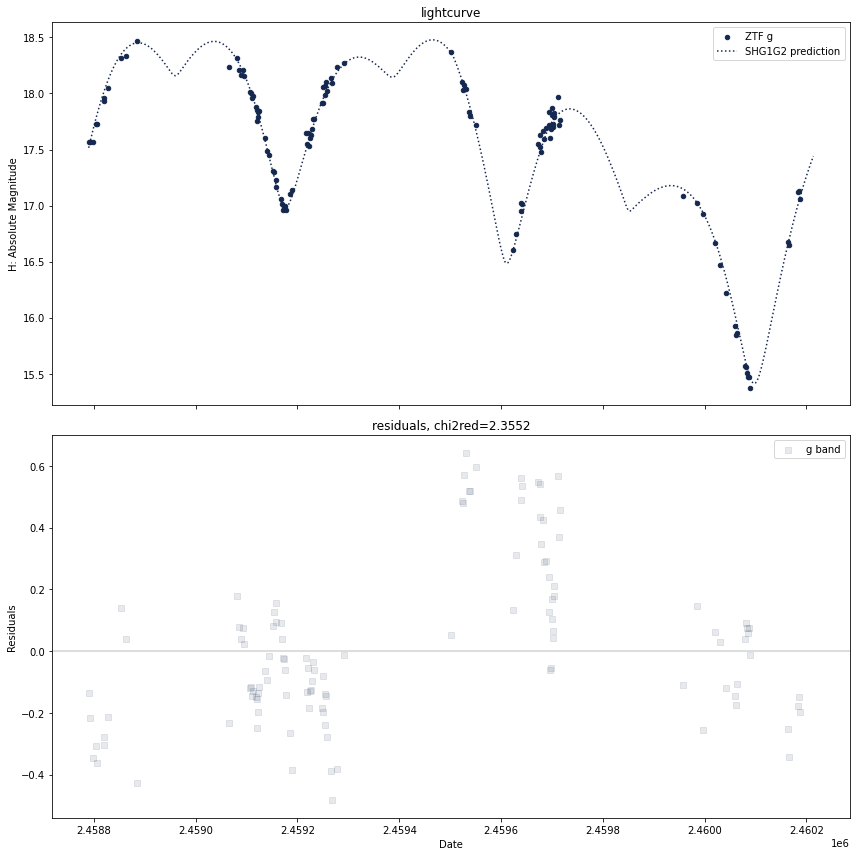

In [14]:
plot_lightcurve(shg1g2, save_plot)

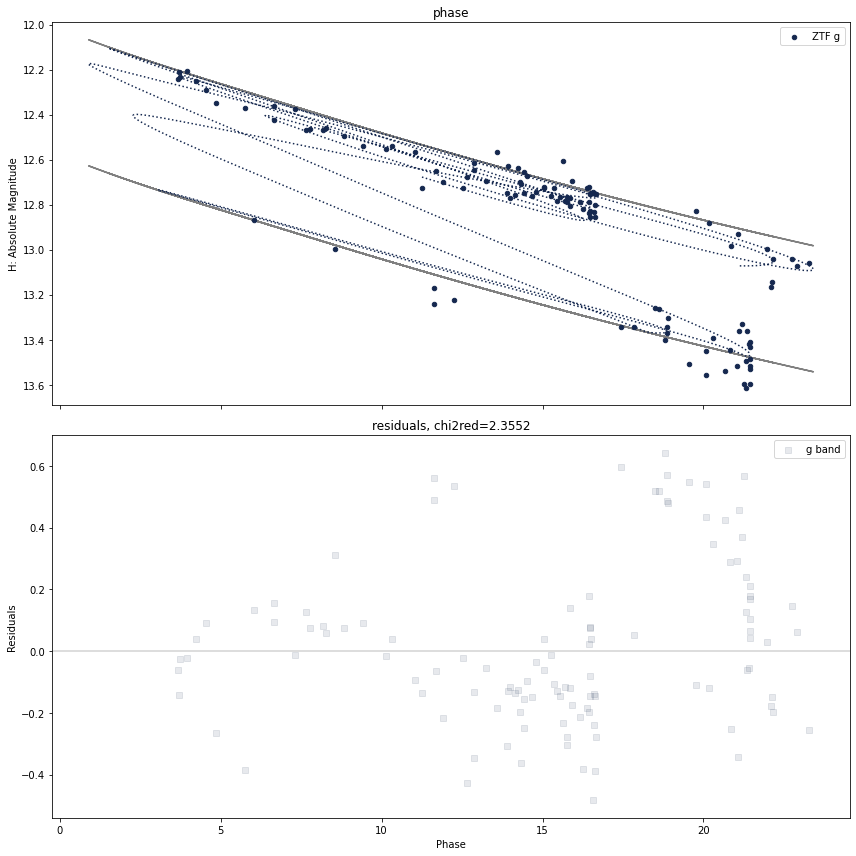

In [15]:
plot_phase(shg1g2, save_plot)

#### 'r' band

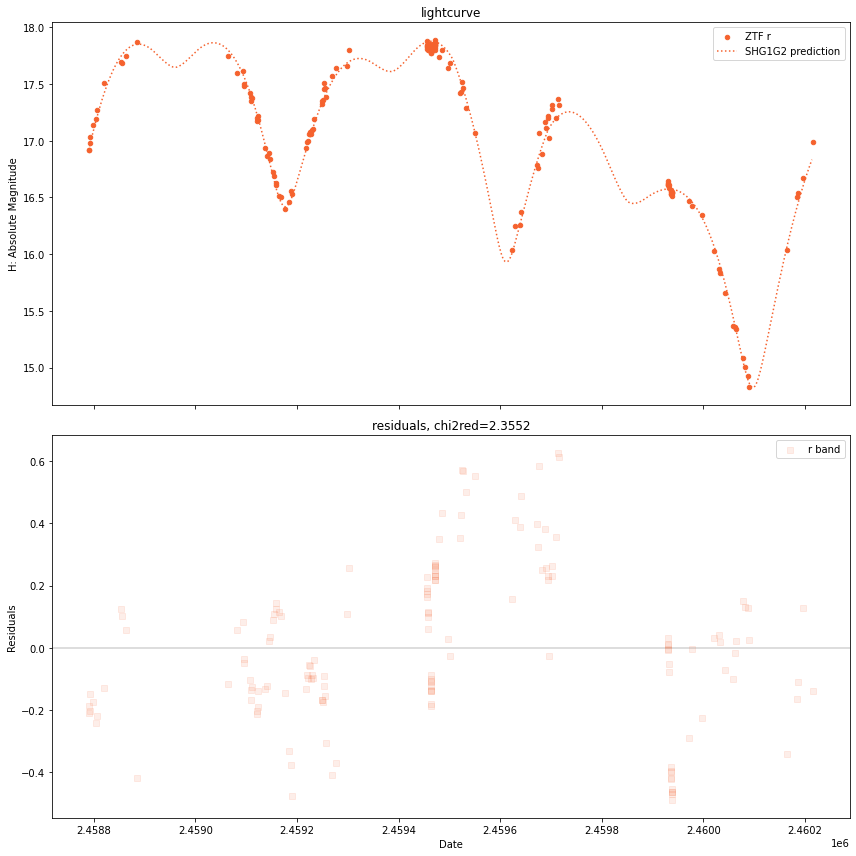

In [16]:
shg1g2.reset_filter('r')
plot_lightcurve(shg1g2, save_plot)

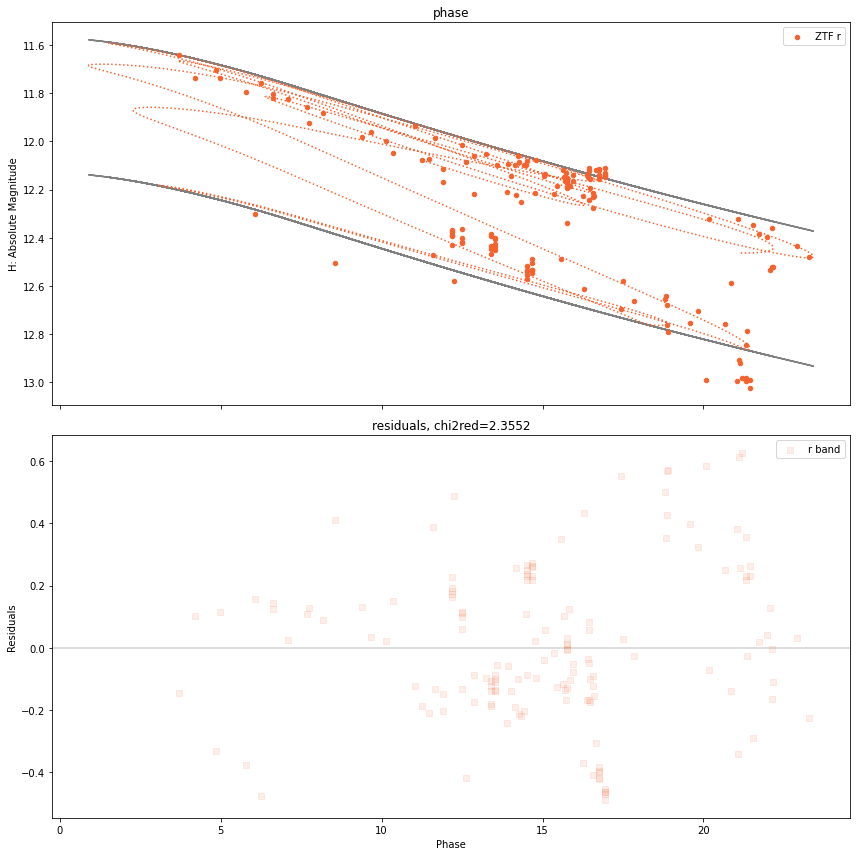

In [17]:
plot_phase(shg1g2, save_plot)

### Compare models

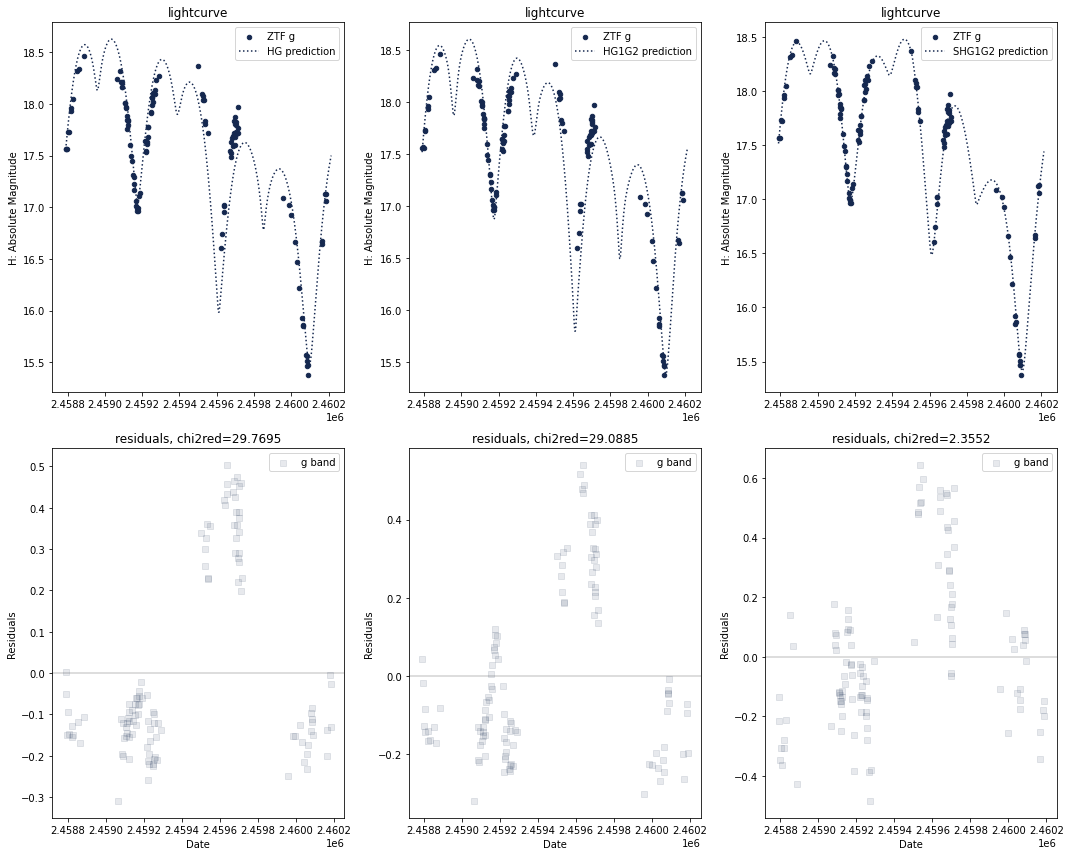

In [18]:
compare_model_lc(hg, hg1g2, shg1g2, "g", save_plot)

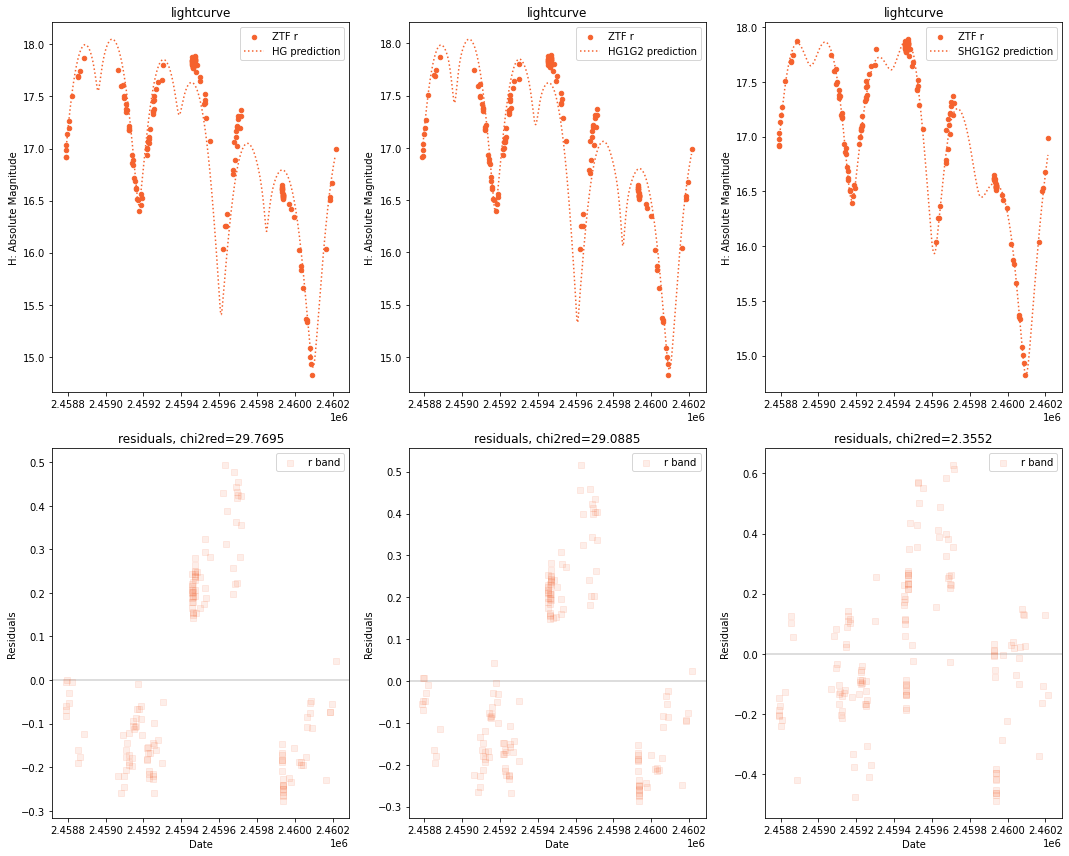

In [19]:
compare_model_lc(hg, hg1g2, shg1g2, "r", save_plot)

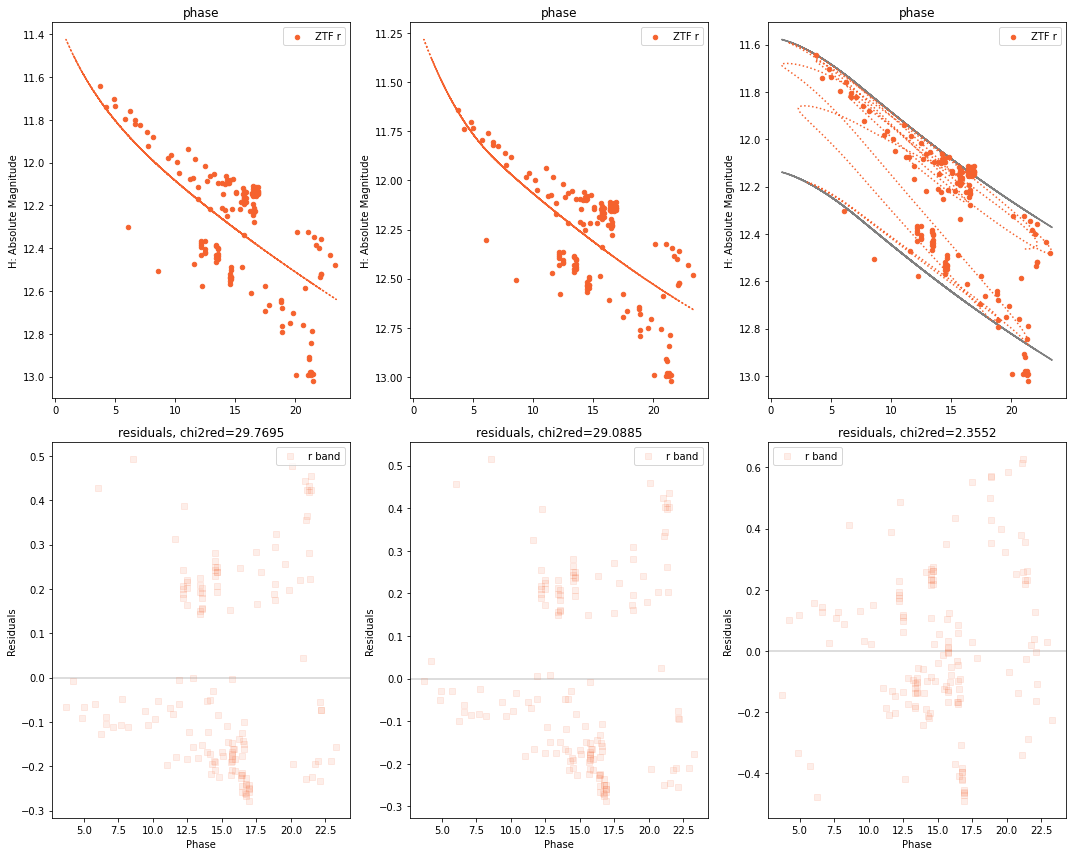

In [20]:
compare_model_phase(hg, hg1g2, shg1g2, "r", save_plot)

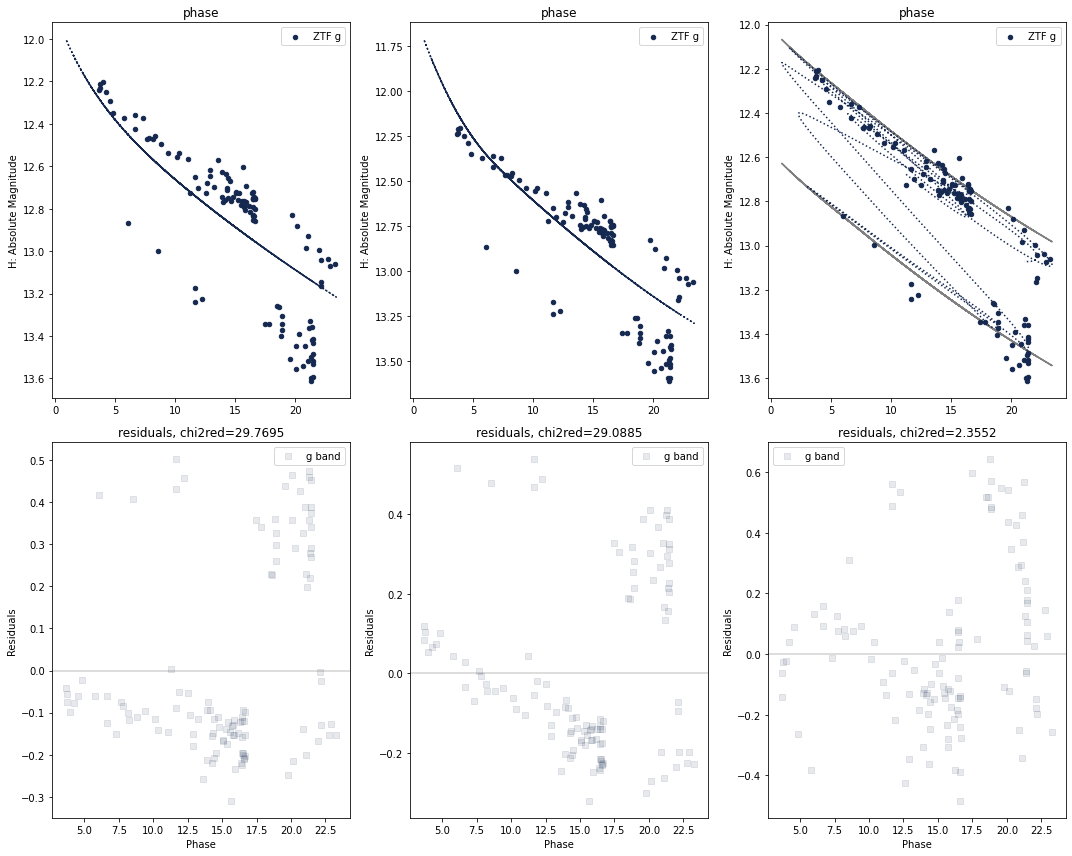

In [21]:
compare_model_phase(hg, hg1g2, shg1g2, "g", save_plot)

### Multi band lightcurve

#### Lightcurve

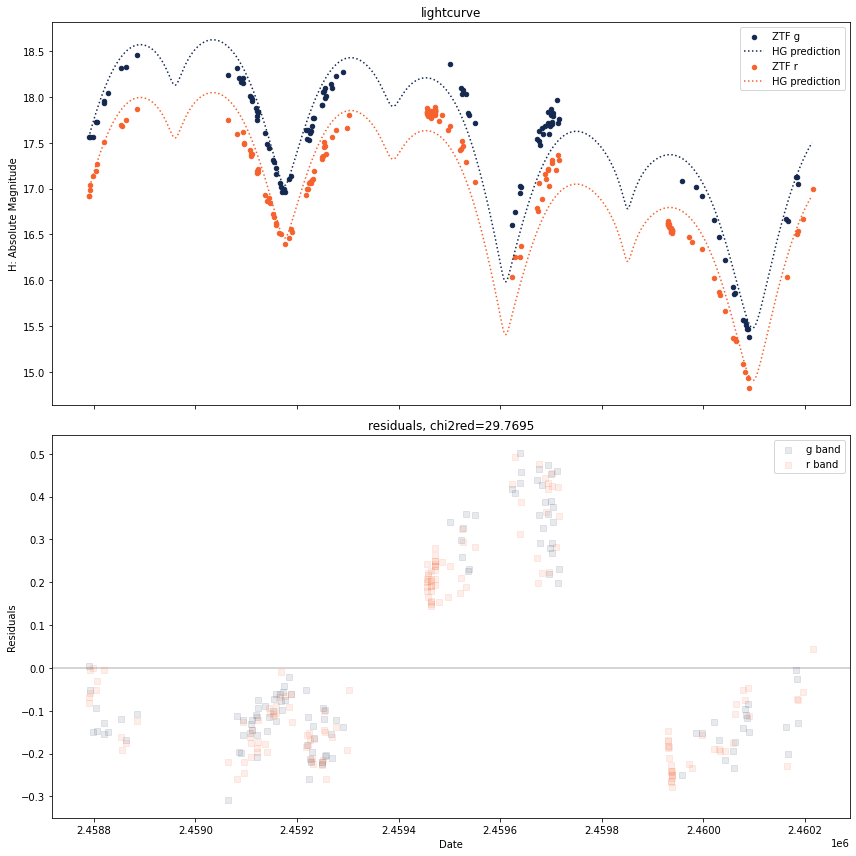

In [22]:
plot_lc_multiband(hg, save_plot)

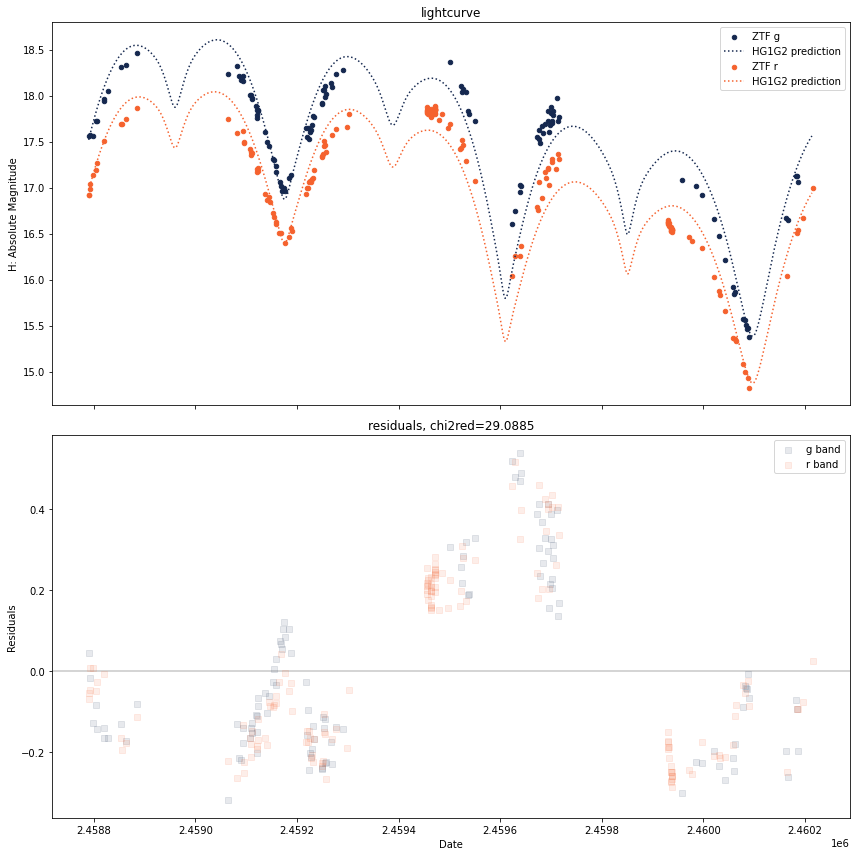

In [23]:
plot_lc_multiband(hg1g2, save_plot)

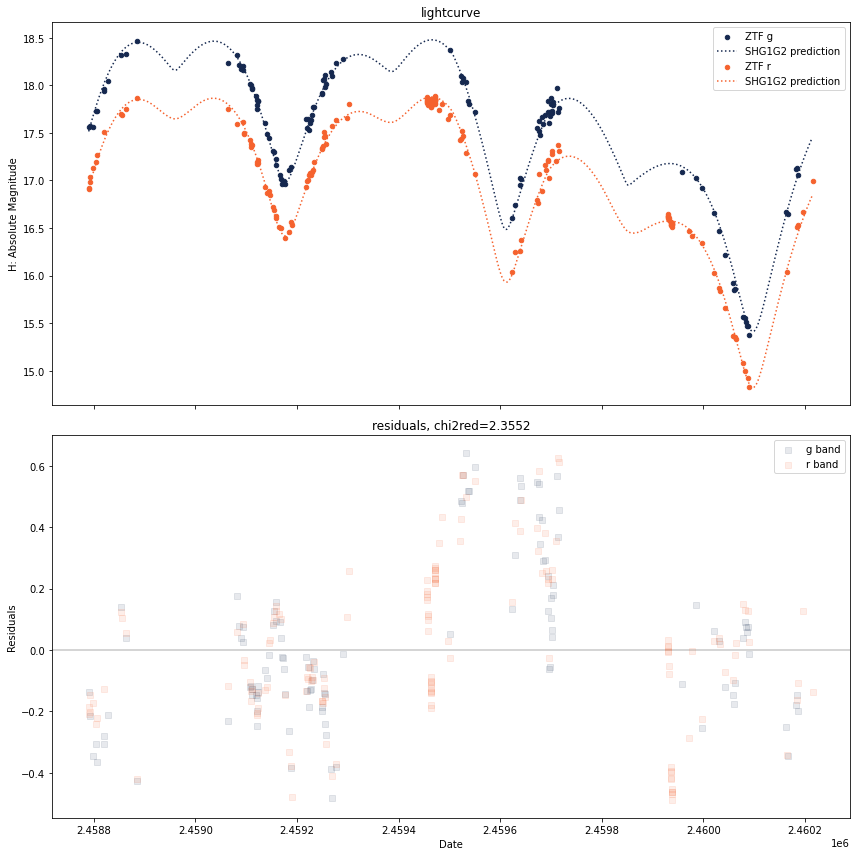

In [24]:
plot_lc_multiband(shg1g2, save_plot)

#### Phase

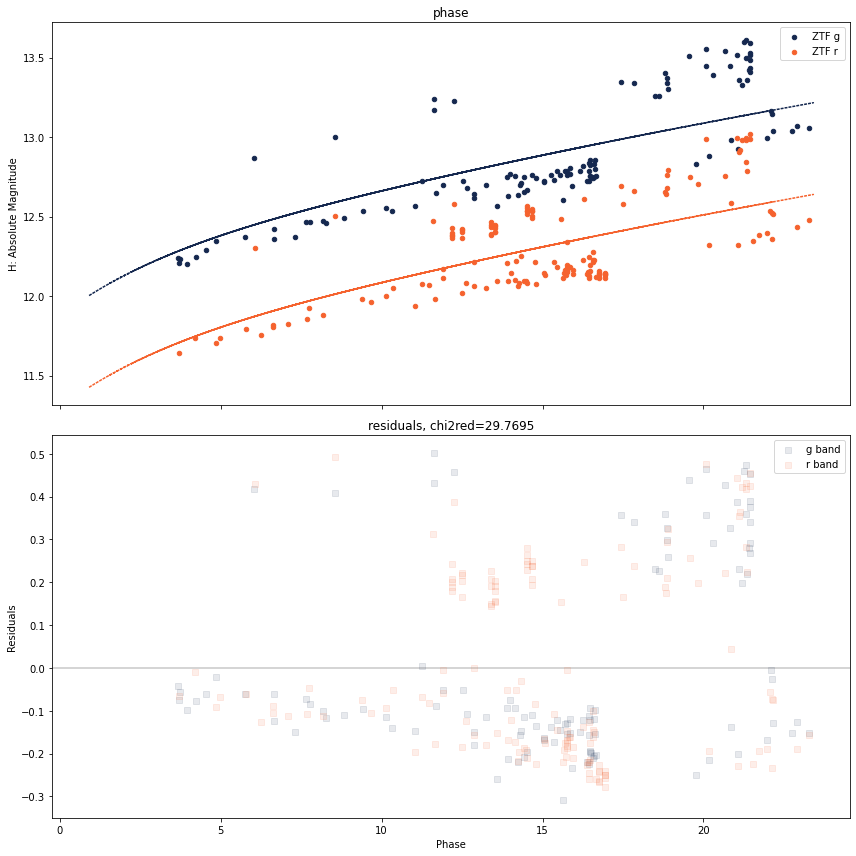

In [25]:
plot_phase_multiband(hg, save_plot)

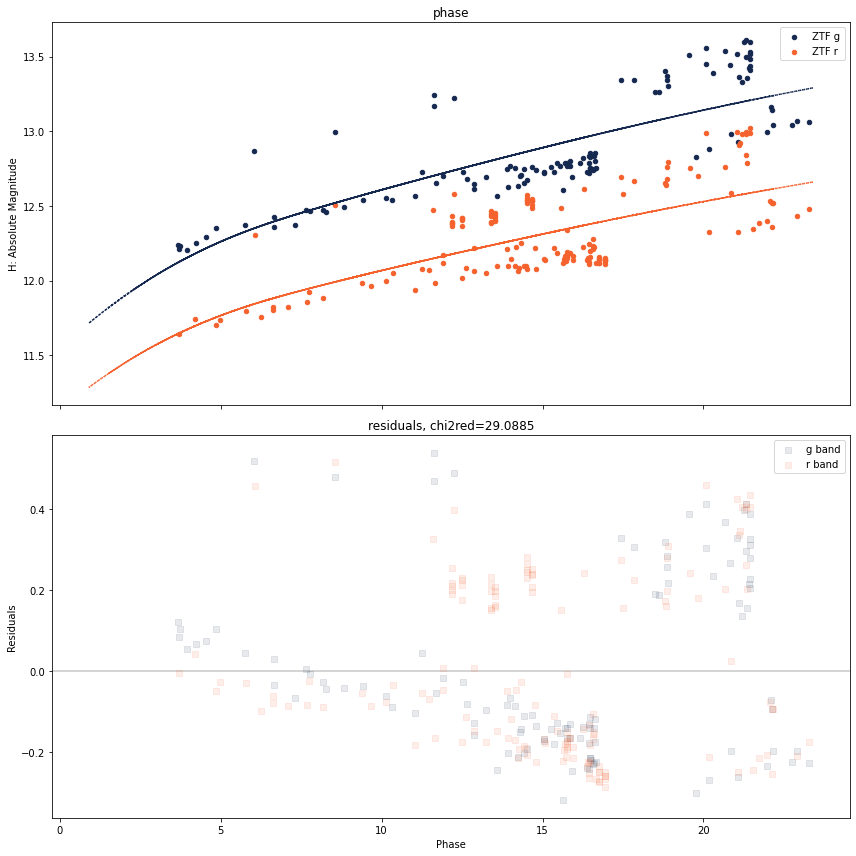

In [26]:
plot_phase_multiband(hg1g2, save_plot)

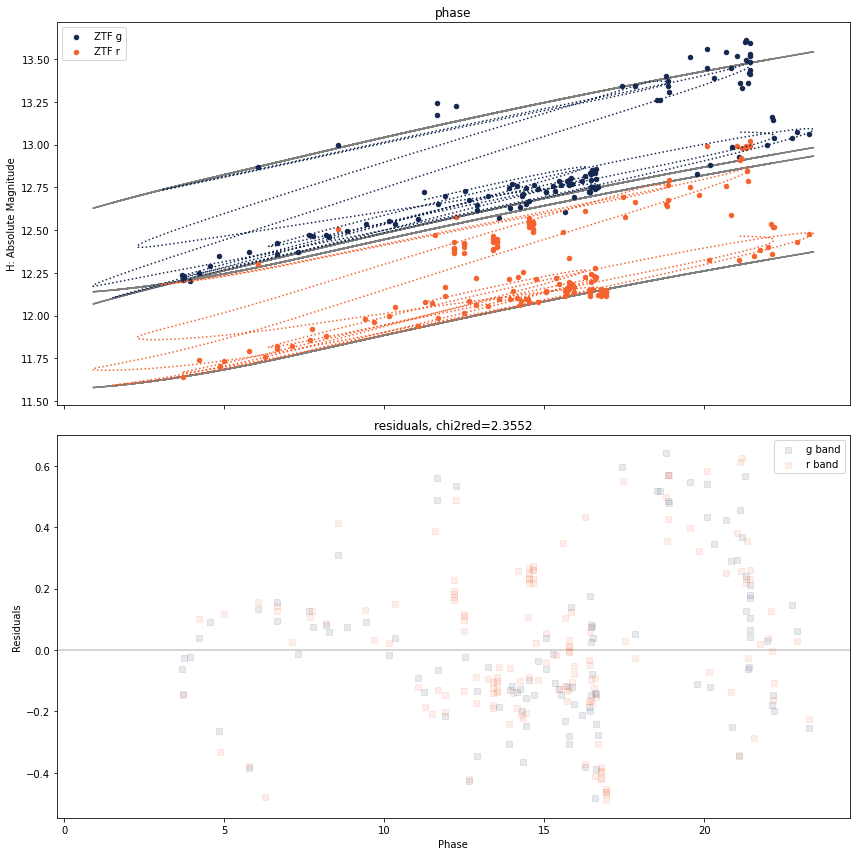

In [27]:
plot_phase_multiband(shg1g2, save_plot)

NameError: name 'ztf' is not defined

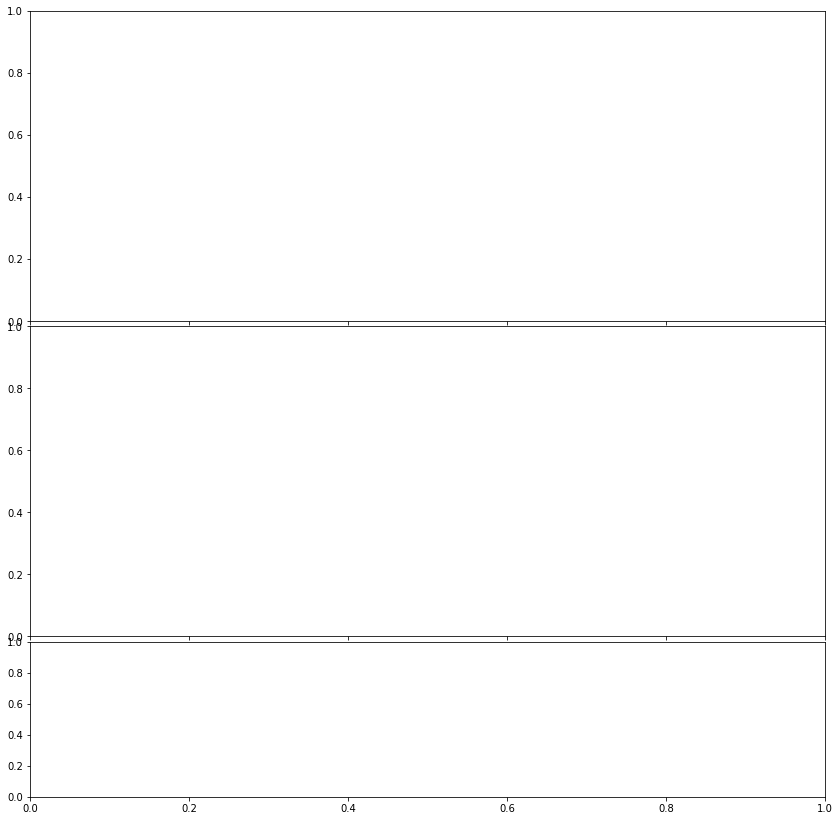

In [28]:
# Mag vs Time
fig, ax = plt.subplots(3, 1, figsize=(12,12), #fs.figsize(1), 
                       sharex=True, 
                       gridspec_kw={
                           'top':0.995, 
                           'left':0.075,
                           'right':0.995,
                           'bottom':0.085,
                           'hspace':0.02, 
                           'height_ratios': [2,2,1]
                       })
# ZTF Colors and Colors
colors = ['#15284F', '#F5622E']

show_HG = False
show_HG1G2 = False
show_HG1G2sp = False
show_sHG1G2 = True
# cond = ztf['i:fid']==fi+1
res_HG = False
res_HG1G2 = False
res_HG1G2sp = False
res_sHG1G2 = True

for fi, filt in enumerate(['g','r']):

    # --------------------------------------------------------------------------------
    # Plot ZTF observations
    cond = ztf['i:fid']==fi+1
    if filt=='g':
        color_corr = V_minus_g
    else:
        color_corr = V_minus_r
    
    ax[fi].scatter( ztf.loc[cond,'Date'], ztf.loc[cond,'i:magpsf'],
                    s=20, marker='o', 
                    color=colors[fi], 
                    label=f'ZTF {filt}' )
    
    # --------------------------------------------------------------------------------
    # HG model
    # Get Parameters
    H = data.loc[data.ssnamenr==target, 'HG_H_{}'.format(filt)].values[0]
    G = data.loc[data.ssnamenr==target, 'HG_G_{}'.format(filt)].values[0]
    if fi==0: print(f'HG       : {H:5.2f}  {G:4.2f}')
    
    # Linear Plot 
    if show_HG:
        pred_mag = finkus.func_hg(np.radians(eph['Phase']), H, G) \
                 + dist_reduction( eph['Dobs'], eph['Dhelio'] )
        ax[fi].plot( eph['Date'], pred_mag, color=colors[fi], linestyle='dotted', label=f'HG' )

        # if filt=='r':
        #     pred_mag = finkus.func_hg(np.radians(eph['Phase']), H, G) \
        #              + dist_reduction( eph['Dobs'], eph['Dhelio'] ) \
        #              - V_minus_r_fink
        #     ax[fi].plot( eph['Date'], pred_mag, color=colors[fi], linestyle='dotted', label=f'V-r=0.13' )

            
            
    # Plot residuals
    if res_HG:
        phase = ztf['Phase']
        pred_mag = finkus.func_hg(np.radians(phase), H, G)
        ax[2].scatter( ztf.loc[:,'Date'],
                   ztf.loc[:,'i:magpsf'] \
                    - dist_reduction( ztf.loc[:,'Dobs'], ztf.loc[:,'Dhelio'] ) \
                    - pred_mag, 
               color=colors[fi], alpha=0.1, marker='s', label=f'HG' )
        
    # --------------------------------------------------------------------------------
    # HG1G2 model
    # Get Parameters
    H = data.loc[data.ssnamenr==target, 'HG1G2_H_{}'.format(filt)].values[0]
    G1 = data.loc[data.ssnamenr==target, 'HG1G2_G1_{}'.format(filt)].values[0]
    G2 = data.loc[data.ssnamenr==target, 'HG1G2_G2_{}'.format(filt)].values[0]
    if fi==0: print(f'HG1G2    : {H:5.2f}  {G1:4.2f}  {G2:4.2f}')
    
    # Linear Plot 
    if show_HG1G2:
        pred_mag = finkus.func_hg1g2(np.radians(eph['Phase']), H, G1, G2) \
                 + dist_reduction( eph['Dobs'], eph['Dhelio'] )
        ax[fi].plot( eph['Date'], pred_mag, color=colors[fi], linestyle='dashed', label=f'HG1G2' )
    
    # Plot Residuals
    if res_HG1G2:
        pred_mag = finkus.func_hg1g2(np.radians(ztf.loc[cond,'Phase']), H, G1, G2)
        ax[2].scatter( ztf.loc[cond,'Date'],
                   ztf.loc[cond,'i:magpsf'] \
                    - dist_reduction( ztf.loc[cond,'Dobs'], ztf.loc[cond,'Dhelio'] ) \
                    - pred_mag, 
               color=colors[fi], alpha=0.1, marker='s', label=f'HG1G2 {filt}' )

    # --------------------------------------------------------------------------------
    # HG1G2spin model
    # Get Parameters
    # H = data.loc[data.ssnamenr==target, 'HG1G2sp_H'].values[0]
    # G1 = data.loc[data.ssnamenr==target, 'HG1G2sp_G1'].values[0]
    # G2 = data.loc[data.ssnamenr==target, 'HG1G2sp_G2'].values[0]
    # ra0 = data.loc[data.ssnamenr==target, 'HG1G2sp_RA0'].values[0]
    # dec0 = data.loc[data.ssnamenr==target, 'HG1G2sp_DEC0'].values[0]
    # R = data.loc[data.ssnamenr==target, 'sHG1G2_R'].values[0]
    # if fi==0: print(f'HG1G2spin: {H:5.2f}  {G1:4.2f}  {G2:4.2f}')

    # # Plot 
    # if show_HG1G2sp:
    #     radec = SkyCoord( eph.RA, eph.DEC, unit=(u.hourangle, u.deg) )
    #     pha = np.transpose([[i, j, k] for i, j, k in
    #                         zip(np.radians(eph.Phase),
    #                             np.radians(radec.ra.deg),
    #                             np.radians(radec.dec.deg))])
    #     pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0)) \
    #              + dist_reduction( eph['Dobs'], eph['Dhelio'] ) \
    #              - color_corr
    #     ax[fi].plot( eph['Date'], pred_mag, color=colors[fi], linestyle='dashdot', label=f'HG1G2 spin' )

    # # Plot residuals
    # if res_HG1G2sp:
    #     pha = np.transpose([[i, j, k] for i, j, k in
    #                         zip(np.radians(ztf.loc[cond,'Phase']),
    #                             np.radians(ztf.loc[cond,'RA']),
    #                             np.radians(ztf.loc[cond,'Dec']))])
    #     pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0)) - color_corr
    #     ax[2].scatter( ztf.loc[cond,'Date'], 
    #                ztf.loc[cond,'i:magpsf'] \
    #                 - dist_reduction( ztf.loc[cond,'Dobs'], ztf.loc[cond,'Dhelio'] )\
    #                 - pred_mag, 
    #            color=colors[fi], alpha=0.1, marker='s', label=f'HG1G2sp' )  
        
        
    # --------------------------------------------------------------------------------
    # Hybrid model
    # Get Parameters
    H = data.loc[data.ssnamenr==target, f'sHG1G2_H_{filt}'].values[0]
    G1 = data.loc[data.ssnamenr==target, f'sHG1G2_G1_{filt}'].values[0]
    G2 = data.loc[data.ssnamenr==target, f'sHG1G2_G2_{filt}'].values[0]
    ra0 = data.loc[data.ssnamenr==target, 'sHG1G2_RA0'].values[0]
    dec0 = data.loc[data.ssnamenr==target, 'sHG1G2_DEC0'].values[0]
    R = data.loc[data.ssnamenr==target, 'sHG1G2_R'].values[0]
    rms = data.loc[data.ssnamenr==target, 'sHG1G2_rms'].values[0]
    print(f'HG21G1  {filt}: {H:5.2f}  {G1:4.2f}  {G2:4.2f}   {ra0:4.1f}  {dec0:4.1f}   {R:4.2f}    {rms:.3f}')

    # Plot
    if show_sHG1G2:
        radec = SkyCoord( eph.RA, eph.DEC, unit=(u.hourangle, u.deg) )
        pha = np.transpose([[i, j, k] for i, j, k in
                            zip(np.radians(eph.Phase),
                                np.radians(radec.ra.deg),
                                np.radians(radec.dec.deg))])
        pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0))  \
                 + dist_reduction( eph['Dobs'], eph['Dhelio'] ) 
        ax[fi].plot( eph['Date'], pred_mag, color=colors[fi], label=f'SHG1G2' )

#         x = eph['Date']
#         y = pred_mag

#         points = np.array([x, y]).T.reshape(-1, 1, 2)
#         segments = np.concatenate([points[:-1], points[1:]], axis=1)


#         norm = plt.Normalize(x.min(), x.max())
#         lc = LineCollection(segments, cmap='Oranges', norm=norm, label=f'HG1G2 Hybrid')

#         lc.set_array(x)
#         lc.set_linewidth(2)
#         line = ax[fi].add_collection(lc)
        # ax[fi].plot( eph['Date'], pred_mag, c=col_date, cmap='Oranges', label=f'HG1G2 Hybrid' )

    # Plot Residuals
    if res_sHG1G2:
        pha = np.transpose([[i, j, k] for i, j, k in
                            zip(np.radians(ztf.loc[cond,'Phase']),
                                np.radians(ztf.loc[cond,'RA']),
                                np.radians(ztf.loc[cond,'Dec']))])
        pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0)) 
        ax[2].scatter( ztf.loc[cond,'Date'], 
                       ztf.loc[cond,'i:magpsf'] \
                        - dist_reduction( ztf.loc[cond,'Dobs'], ztf.loc[cond,'Dhelio'] ) \
                        - pred_mag, 
                   color=colors[fi], label=f'SHG1G2 {filt}' )
    
    
    # ax[fi].set_ylabel(f'Apparent magnitude in {filt}')
    ax[fi].legend(ncol=2)#loc='upper right')
    

# Residuals
ax[2].axhline(0, color='lightgray', zorder=-100)
ax[2].set_ylim(-0.6,0.6)
ax[2].legend(ncol=4, loc='upper center')
ax[2].set_ylabel('Residuals')
    
fig.text(0.01, 0.63, 'Apparent magnitude',  va='center', rotation='vertical')

    
# Axes
ax[2].set_xlabel('Time / days')

# fig.savefig(f'{data_fink}/gfx_obs/{target}-time.png', facecolor='white')
# fig.savefig(f'{data_fink}/gfx_obs/{target}-time.pgf', facecolor='white')
plt.show()

In [ ]:
# Mag vs Phase
fig, ax = plt.subplots(3, 1, figsize=(15,8), 
                       sharex=True, 
                       gridspec_kw={
                           'hspace':0.02, 
                           'height_ratios': [2,2,1]
                       })

# ZTF Colors and Colors
colors = ['#15284F', '#F5622E']
       

show_HG = False
show_HG1G2 = False
show_HG1G2sp = False
show_sHG1G2 = True

res_HG = False
res_HG1G2 = False
res_HG1G2sp = False
res_sHG1G2 = True


for fi, filt in enumerate(['g','r']):

    # --------------------------------------------------------------------------------
    # Plot ZTF observations
    cond = ztf['i:fid']==fi+1
    if filt=='g':
        color_corr = V_minus_g
    else:
        color_corr = V_minus_r
    
    ax[fi].scatter( ztf.loc[cond,'Phase'],
                    ztf.loc[cond,'i:magpsf'] - dist_reduction( ztf.loc[cond,'Dobs'], ztf.loc[cond,'Dhelio'] ) ,
                    s=20, marker='o', 
                    color=colors[fi], 
                    label=f'ZTF {filt}' )
    
    # --------------------------------------------------------------------------------
    # HG model
    # Get Parameters
    H = data.loc[data.ssnamenr==target, 'HG_H_{}'.format(filt)].values[0]
    G = data.loc[data.ssnamenr==target, 'HG_G_{}'.format(filt)].values[0]
    if fi==0: print(f'HG       : {H:5.2f}  {G:4.2f}')
    
    # Linear Plot 
    if show_HG:
        pred_mag = finkus.func_hg(np.radians(eph['Phase']), H, G)
        ax[fi].plot( eph['Phase'], pred_mag, color=colors[fi], linestyle='dotted', label=f'HG' )
    
    # Plot residuals
    if res_HG:
        phase = ztf['Phase']
        pred_mag = finkus.func_hg(np.radians(phase), H, G)
        ax[2].scatter( ztf.loc[:,'Phase'],
                   ztf.loc[:,'i:magpsf'] \
                    - dist_reduction( ztf.loc[:,'Dobs'], ztf.loc[:,'Dhelio'] ) \
                    - pred_mag, 
               color=colors[fi], alpha=0.1, marker='s', label=f'HG' )
    
    
    
    # --------------------------------------------------------------------------------
    # HG1G2 model
    # Get Parameters
    H = data.loc[data.ssnamenr==target, 'HG1G2_H_{}'.format(filt)].values[0]
    G1 = data.loc[data.ssnamenr==target, 'HG1G2_G1_{}'.format(filt)].values[0]
    G2 = data.loc[data.ssnamenr==target, 'HG1G2_G2_{}'.format(filt)].values[0]
    if fi==0: print(f'HG1G2    : {H:5.2f}  {G1:4.2f}  {G2:4.2f}')
    
    # Plot 
    if show_HG1G2:
        pred_mag = finkus.func_hg1g2(np.radians(eph['Phase']), H, G1, G2) - color_corr
        ax[fi].plot( eph['Phase'], pred_mag, color=colors[fi], linestyle='dashed', label=f'HG1G2' )
    
    # Plot Residuals
    if res_HG1G2:
        pred_mag = finkus.func_hg1g2(np.radians(ztf.loc[cond,'Phase']), H, G1, G2) - color_corr
        ax[2].scatter( ztf.loc[cond,'Phase'],
                   ztf.loc[cond,'i:magpsf'] \
                    - dist_reduction( ztf.loc[cond,'Dobs'], ztf.loc[cond,'Dhelio'] ) \
                    - pred_mag, 
               color=colors[fi], alpha=0.1, marker='s', label=f'HG1G2 {filt}' )

    
    # --------------------------------------------------------------------------------
    # HG1G2spin model
    # Get Parameters
    # H = data.loc[data.ssnamenr==target, 'HG1G2sp_H'].values[0]
    # G1 = data.loc[data.ssnamenr==target, 'HG1G2sp_G1'].values[0]
    # G2 = data.loc[data.ssnamenr==target, 'HG1G2sp_G2'].values[0]
    # ra0 = data.loc[data.ssnamenr==target, 'HG1G2sp_RA0'].values[0]
    # dec0 = data.loc[data.ssnamenr==target, 'HG1G2sp_DEC0'].values[0]
    # R = data.loc[data.ssnamenr==target, 'sHG1G2_R'].values[0]
    # if fi==0: print(f'HG1G2spin: {H:5.2f}  {G1:4.2f}  {G2:4.2f}')

    # # Linear Plot 
    # if show_HG1G2sp:
    #     radec = SkyCoord( eph.RA, eph.DEC, unit=(u.hourangle, u.deg) )
    #     pha = np.transpose([[i, j, k] for i, j, k in
    #                         zip(np.radians(eph.Phase),
    #                             np.radians(radec.ra.deg),
    #                             np.radians(radec.dec.deg))])
    #     pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0)) - color_corr
    #     ax[fi].plot( eph['Phase'], pred_mag, color=colors[fi], linestyle='dashdot', label=f'HG1G2 spin' )
    
    # # Plot residuals
    # if res_HG1G2sp:
    #     pha = np.transpose([[i, j, k] for i, j, k in
    #                         zip(np.radians(ztf.loc[cond,'Phase']),
    #                             np.radians(ztf.loc[cond,'RA']),
    #                             np.radians(ztf.loc[cond,'Dec']))])
    #     pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0)) - color_corr
    #     ax[2].scatter( ztf.loc[cond,'Phase'],
    #                ztf.loc[cond,'i:magpsf'] \
    #                 - dist_reduction( ztf.loc[cond,'Dobs'], ztf.loc[cond,'Dhelio'] ) \
    #                 - pred_mag, 
    #            color=colors[fi], alpha=0.1, marker='s', label=f'HG1G2sp' )
    
    
    # --------------------------------------------------------------------------------
    # Hybrid model
    # Get Parameters
    H = data.loc[data.ssnamenr==target, f'sHG1G2_H_{filt}'].values[0]
    G1 = data.loc[data.ssnamenr==target, f'sHG1G2_G1_{filt}'].values[0]
    G2 = data.loc[data.ssnamenr==target, f'sHG1G2_G2_{filt}'].values[0]
    ra0 = data.loc[data.ssnamenr==target, 'sHG1G2_RA0'].values[0]
    dec0 = data.loc[data.ssnamenr==target, 'sHG1G2_DEC0'].values[0]
    R = data.loc[data.ssnamenr==target, 'sHG1G2_R'].values[0]
    print(f'HG21G1  {filt}: {H:5.2f}  {G1:4.2f}  {G2:4.2f}   {ra0:4.1f}  {dec0:4.1f}   {R:4.2f}')

    # Nice linear Plot
    if show_sHG1G2:
        radec = SkyCoord( eph.RA, eph.DEC, unit=(u.hourangle, u.deg) )
        pha = np.transpose([[i, j, k] for i, j, k in
                            zip(np.radians(eph.Phase),
                                np.radians(radec.ra.deg),
                                np.radians(radec.dec.deg))])
        pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0)) 
        ax[fi].plot( eph['Phase'], pred_mag, color=colors[fi], label=f'Hybrid' )

        
#         c = eph['Date']
#         x = eph['Phase']
#         y = pred_mag

#         points = np.array([x, y]).T.reshape(-1, 1, 2)
#         segments = np.concatenate([points[:-1], points[1:]], axis=1)


#         norm = plt.Normalize(c.min(), c.max())
#         lc = LineCollection(segments, cmap='plasma', norm=norm, label=f'HG1G2 Hybrid')

#         lc.set_array(c)
#         lc.set_linewidth(2)
#         line = ax[fi].add_collection(lc)
        
        
    
    # Plot Residuals
    if res_sHG1G2:
        pha = np.transpose([[i, j, k] for i, j, k in
                            zip(np.radians(ztf.loc[cond,'Phase']),
                                np.radians(ztf.loc[cond,'RA']),
                                np.radians(ztf.loc[cond,'Dec']))])
        pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0)) 
        ax[2].scatter( ztf.loc[cond,'Phase'],
                       ztf.loc[cond,'i:magpsf'] \
                        - dist_reduction( ztf.loc[cond,'Dobs'], ztf.loc[cond,'Dhelio'] ) \
                        - pred_mag, 
                   color=colors[fi], label=f'Hybrid {filt}' )
    
    
    # Axes
    ax[fi].set_ylim( np.flip( ax[fi].get_ylim() ) )
    ax[fi].set_ylabel(f'Apparent magnitude in {filt}')
    ax[fi].legend(loc='upper right')
    

# Residuals
ax[2].axhline(0, color='lightgray', zorder=-100)
ax[2].legend(loc='center right')
    
    
# Axes
ax[2].set_xlabel('Phase / deg')
ax[2].set_xlim(0)

# fig.savefig(f'{data_fink}/gfx_obs/{target}-phase.png', facecolor='white')

In [ ]:

# Special Dedicace a Julien :-)

# How to find oppositions
p_conj = eph['Elong.'].isin( eph['Elong.'].values[argrelextrema(eph['Elong.'].values, np.greater)[0]] )
nb_oppo = len(eph[p_conj])

#
# Compute Lambda
coords = SkyCoord( eph.RA, eph.DEC, unit=(u.hourangle, u.deg) )

ra0 = data.loc[data.ssnamenr==target, 'sHG1G2_RA0'].values[0]
dec0 = data.loc[data.ssnamenr==target, 'sHG1G2_DEC0'].values[0]

ra = np.radians(coords.ra.deg)
dec = np.radians(coords.dec.deg)
cos_lambda = np.sin(dec)*np.sin(dec0) + np.cos(dec)*np.cos(dec0)*np.cos(ra-ra0)
eph['cosLambda'] = cos_lambda

# Graphically
fig, ax = plt.subplots()

# First part
cond = eph.Date < eph.loc[p_conj,'Date'].values[0]
ax.scatter( eph.loc[cond,'Date'], eph.loc[cond,'cosLambda'] )

# All middle part until last
for ko in range(1,nb_oppo):
    cond = (eph.Date > eph.loc[p_conj,'Date'].values[ko-1]) & (eph.Date < eph.loc[p_conj,'Date'].values[ko])
    ax.scatter( eph.loc[cond,'Date'], eph.loc[cond,'cosLambda'] )

# Last opposition
cond = eph.Date > eph.loc[p_conj,'Date'].values[-1]
ax.scatter( eph.loc[cond,'Date'], eph.loc[cond,'cosLambda'] )

for ko in range(nb_oppo):
    ax.axvline( eph.loc[p_conj,'Date'].values[ko] )
